In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from gensim.models import word2vec
from nltk.tokenize import word_tokenize
from keras import Sequential
from keras.layers import Dense, Embedding, LSTM, Dropout,Flatten
from wordcloud import WordCloud, STOPWORDS
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

### 1. About the Data

In [2]:
# initialize the random seed
np.random.seed(0)

# load datasets
trainset = pd.read_csv('dataset/train.txt', sep=';', names=['text', 'emotion'])
testset = pd.read_csv('dataset/test.txt', sep=';', names=['text', 'emotion'])
valset = pd.read_csv('dataset/val.txt', sep=';', names=['text', 'emotion'])

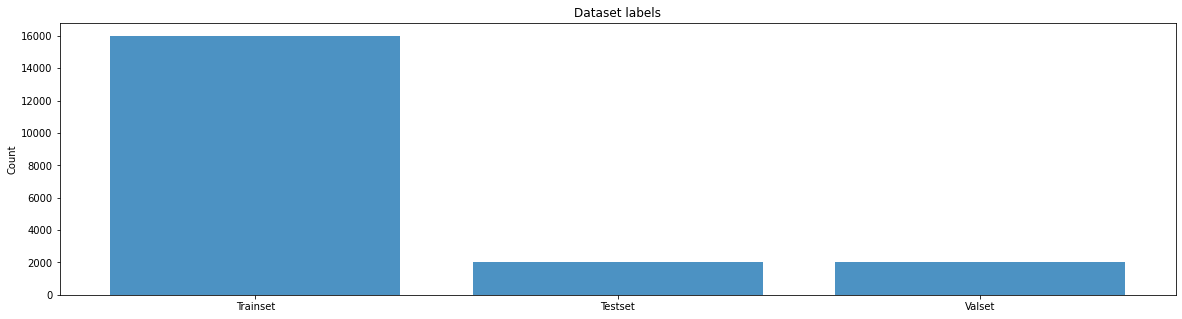

In [3]:
# plot datasets size

dataset_name = ['Trainset', 'Testset', 'Valset']
counts = [len(trainset), len(testset), len(valset)]

y_pos = np.arange(len(dataset_name))
plt.figure(figsize=(20,5))
plt.bar(y_pos, counts, align='center', alpha=0.8)
plt.xticks(y_pos, dataset_name)
plt.ylabel('Count')
plt.title('Dataset labels')

plt.show()

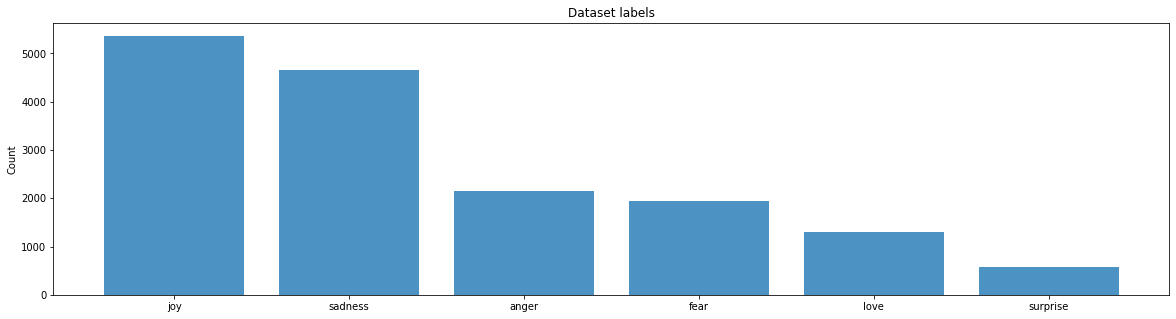

In [4]:
# plot samples count per class

dataset = trainset.copy()
label_counts = dataset.emotion.value_counts().to_dict()

labels = []
counts = []

for label in label_counts:
    labels.append(label)
    counts.append(label_counts[label])

y_pos = np.arange(len(labels))
plt.figure(figsize=(20,5))
plt.bar(y_pos, counts, align='center', alpha=0.8)
plt.xticks(y_pos, labels)
plt.ylabel('Count')
plt.title('Dataset labels')

plt.show()

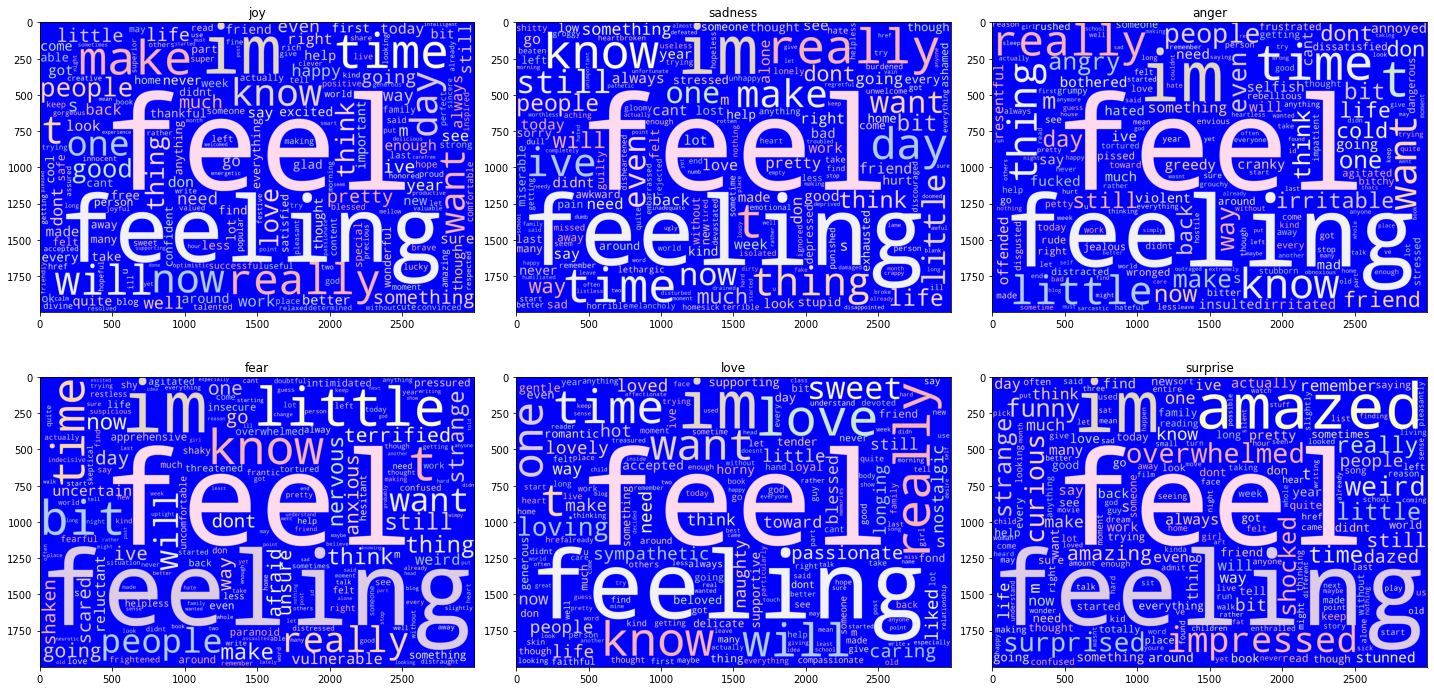

In [5]:
# plot word cloud

texts = {'joy': '', 'sadness': '', 'anger': '', 'fear': '', 'love': '', 'surprise': ''}

for i, row in trainset.iterrows():
    texts[f'{row.emotion}'] += row.text + ' '


# Define a function to plot word cloud
def plot_cloud(texts):
    keys = list(texts)
    fig, axes = plt.subplots(2,3, figsize=(20,10))
    fig.tight_layout()
    for i, ax in enumerate(axes.flat):
        wordcloud = WordCloud(width=3000, height=2000, random_state=1, 
            background_color='blue', colormap='Pastel1', collocations=False, 
            stopwords = STOPWORDS).generate(texts[keys[i]])
        ax.imshow(wordcloud)
        ax.title.set_text(keys[i])

plot_cloud(texts)

## 2. Data Preprocessing and Feature Engineering

### 2.1. OneHot Encoding of the labels

In [6]:
def preprocessing_dateset(dataset):
    _dataset = dataset.copy()
    _dataset["emotion"] = _dataset["emotion"].astype('category')
    _dataset["emotion_label"] = _dataset["emotion"].cat.codes
    return _dataset['text'], tf.one_hot(_dataset["emotion_label"], 6)

# return features and labels of trainset
X_train, y_train = preprocessing_dateset(trainset)

# return features and labels of testset
X_test, y_test = preprocessing_dateset(testset)


# return features and labels of valset
X_val, y_val = preprocessing_dateset(valset)

In [7]:
# tokenized trainset features
tokenized_X_train = [word_tokenize(train_text) for train_text in X_train]

# tokenized testset features
tokenized_X_test = [word_tokenize(test_text) for test_text in X_test]

# tokenized valset features
tokenized_X_val = [word_tokenize(val_text) for val_text in X_val]

In [8]:
def get_categories(dataset):
    _dataset = dataset.copy()
    _dataset["emotion"] = _dataset["emotion"].astype('category')
    return _dataset["emotion"].cat.categories

# print the labels
categories = get_categories(trainset)
categories

Index(['anger', 'fear', 'joy', 'love', 'sadness', 'surprise'], dtype='object')

### 2.2. Word2Vec Model Training using Gensim 

In [9]:
vector_size = 300 # vector size 

# train the word2vec model
w2v_model = word2vec.Word2Vec(
    tokenized_X_train,
    vector_size=vector_size,
    min_count=1,
    sg=1
)

# return the vocabulary list
vocab = w2v_model.wv.key_to_index.keys()

# return the Embedding Matrix
embedding_matrix = w2v_model.wv[vocab]
embedding_matrix.shape

(15210, 300)

In [10]:
# remove Words Out Of Vocabulary
def remove_OOV(sample: list, list_vocab):
    return [token for token in sample if token in list_vocab]

# remove OOV from testset and valset
tokenized_X_test_without_OOV = [remove_OOV(test_sample, vocab) for test_sample in tokenized_X_test]
tokenized_X_val_without_OOV = [remove_OOV(val_sample, vocab) for val_sample in tokenized_X_val]

### 2.3. Prepare the Dataset

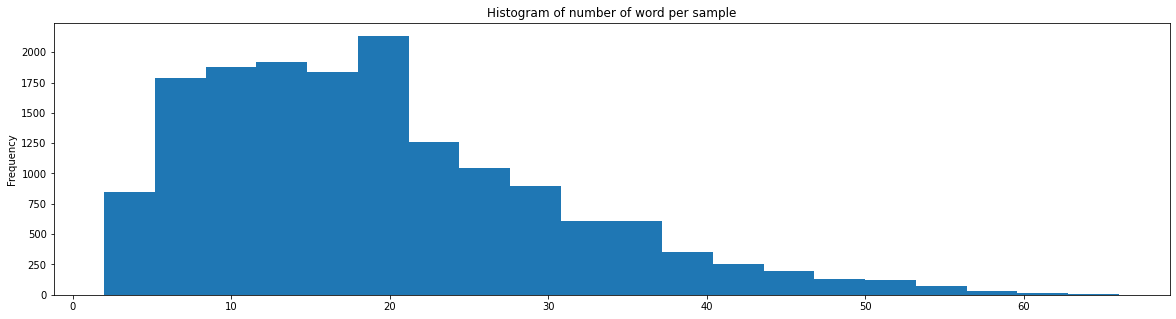

In [11]:
# plot the histogram of words count per sample
word_count_per_sample = [len(seq) for seq in tokenized_X_train]
plt.figure(figsize=(20,5))
plt.hist(word_count_per_sample, 20)
plt.ylabel('Frequency')
plt.title('Histogram of number of word per sample')
plt.show() 

In [12]:
# 50th and 75th percentiles
np.percentile(word_count_per_sample, 50), np.percentile(word_count_per_sample, 75)

(17.0, 25.0)

In [13]:
# we will choose 20 as a maximum of lenght of the sequences because is between 75th and 50th
max_seq_len = int(np.array([np.percentile(word_count_per_sample, 50), np.percentile(word_count_per_sample, 75)]).mean())

print('Max Length: ', max_seq_len)

def w2v_indexed_tokens(w2v_model, list_features):
    return [[w2v_model.wv.key_to_index[token] for token in seq ] for seq in list_features]

indexed_train_features = w2v_indexed_tokens(w2v_model, tokenized_X_train)
indexed_test_features = w2v_indexed_tokens(w2v_model, tokenized_X_test_without_OOV)
indexed_val_features = w2v_indexed_tokens(w2v_model, tokenized_X_val_without_OOV)

X_train = tf.keras.utils.pad_sequences(indexed_train_features, maxlen=max_seq_len)
X_test = tf.keras.utils.pad_sequences(indexed_test_features, maxlen=max_seq_len)
X_val = tf.keras.utils.pad_sequences(indexed_val_features, maxlen=max_seq_len)

Max Length:  21


## 3. Training the Classifier

In [27]:
model = Sequential()

model.add(Embedding(input_dim=embedding_matrix.shape[0], output_dim=embedding_matrix.shape[1], weights=[embedding_matrix], input_length=max_seq_len))
model.add(LSTM(128, return_sequences=True))
model.add(LSTM(128))
model.add(Dense(64, activation='relu'))
model.add(Dense(6, activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 21, 300)           4563000   
                                                                 
 lstm_4 (LSTM)               (None, 21, 128)           219648    
                                                                 
 lstm_5 (LSTM)               (None, 128)               131584    
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 6)                 390       
                                                                 
Total params: 4,922,878
Trainable params: 4,922,878
Non-trainable params: 0
_________________________________________________________________


In [28]:
# compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
tf.config.run_functions_eagerly(True)
tf.data.experimental.enable_debug_mode()

# Adding callbacks for best model checkpoint
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath='models/lstm_with_w2v.hdf5', verbose=True, save_best_only=True, monitor='val_accuracy')
]

# storing model training details to analyze later
history = model.fit(
    X_train, 
    y_train, 
    validation_data=(X_val, y_val), 
    epochs=5,
    steps_per_epoch=200,
    callbacks=callbacks
)

Epoch 1/5
200/200 [==============================] - ETA: 0s - loss: 1.4266 - accuracy: 0.4386
Epoch 1: val_accuracy improved from -inf to 0.58150, saving model to models\lstm_with_w2v.hdf5
200/200 [==============================] - 57s 284ms/step - loss: 1.4266 - accuracy: 0.4386 - val_loss: 1.1252 - val_accuracy: 0.5815
Epoch 2/5
200/200 [==============================] - ETA: 0s - loss: 0.6242 - accuracy: 0.7742
Epoch 2: val_accuracy improved from 0.58150 to 0.84550, saving model to models\lstm_with_w2v.hdf5
200/200 [==============================] - 59s 293ms/step - loss: 0.6242 - accuracy: 0.7742 - val_loss: 0.4618 - val_accuracy: 0.8455
Epoch 3/5
200/200 [==============================] - ETA: 0s - loss: 0.2970 - accuracy: 0.8984
Epoch 3: val_accuracy improved from 0.84550 to 0.86050, saving model to models\lstm_with_w2v.hdf5
200/200 [==============================] - 58s 290ms/step - loss: 0.2970 - accuracy: 0.8984 - val_loss: 0.4287 - val_accuracy: 0.8605
Epoch 4/5
200/200 [===

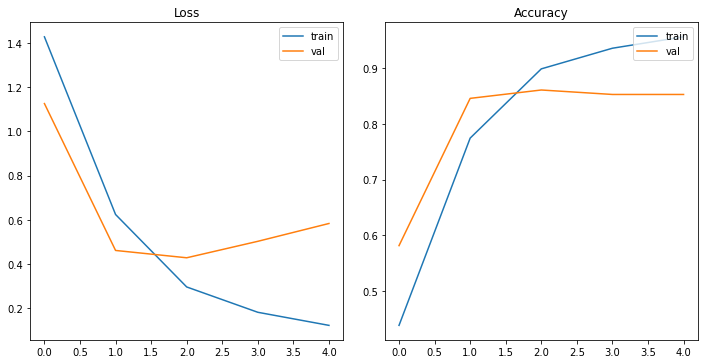

In [29]:
fig, axes = plt.subplots(1,2, figsize=(10,5))
fig.tight_layout()
for i, ax in enumerate(axes.flat):
    metric = 'loss' if i == 0 else 'accuracy'
    ax.plot(history.history[f'{metric}'], label='train')
    ax.plot(history.history[f'val_{metric}'], label='val')
    ax.legend(loc='upper right')
    ax.title.set_text(metric.capitalize())

In [30]:
# load the best model ['models/lstm_with_w2v.hdf5']
model_with_w2v = tf.keras.models.load_model('models/lstm_with_w2v.hdf5')
predictions = model_with_w2v.predict(X_test)
y_pred_one_hot_encoded = (predictions > 0.5).astype("int32")
y_pred = np.array(tf.argmax(y_pred_one_hot_encoded, axis=1))
y_true = np.array(tf.argmax(y_test, axis=1))
y_pred.shape, y_true.shape

63/63 [==============================] - 3s 53ms/step


((2000,), (2000,))

In [31]:
print(classification_report(y_true, y_pred, target_names=categories))

              precision    recall  f1-score   support

       anger       0.65      0.88      0.75       275
        fear       0.86      0.82      0.84       224
         joy       0.89      0.89      0.89       695
        love       0.76      0.75      0.75       159
     sadness       0.94      0.86      0.90       581
    surprise       0.84      0.48      0.62        66

    accuracy                           0.85      2000
   macro avg       0.82      0.78      0.79      2000
weighted avg       0.86      0.85      0.85      2000



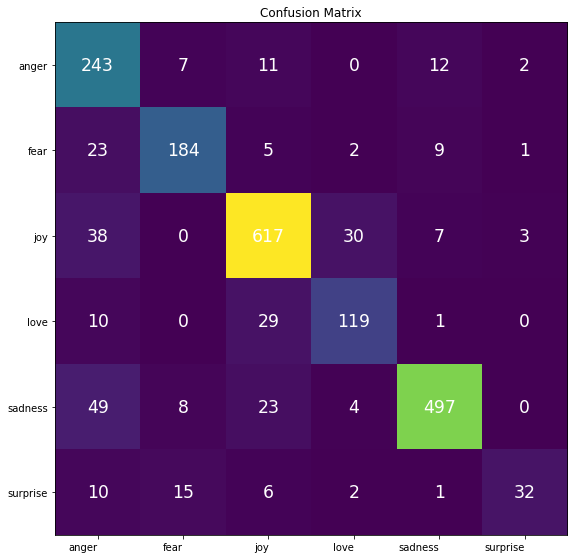

In [32]:
c_matrix = confusion_matrix(y_true, y_pred)

fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(c_matrix)
# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(categories)), labels=categories)
ax.set_yticks(np.arange(len(categories)), labels=categories)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=0, ha="right", rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(categories)):
    for j in range(len(categories)):
        ax.text(j, i, c_matrix[i, j], ha="center", va="center", color="w", size='xx-large')
        pass
ax.set_title("Confusion Matrix")
fig.tight_layout()
plt.show()